# Conservation Analysis of Genomic Features

This notebook analyzes conservation patterns in alternative transcript regions using PhyloCSF and PhyloP scores. The analysis pipeline is designed to handle multiple types of genomic features:
- N-terminal extensions (ctes)
- C-terminal extensions (CTEs)
- Intronic regions

## Setup
First, we'll import required libraries and set up our basic configuration. We use:
- `polars` for efficient data manipulation
- `pyranges` for genomic icterval operations
- `pyBigWig` for accessing conservation scores
- `numpy` for numerical operations
- `matplotlib` and `seaborn` for visualization

In [6]:
# Standard libraries
from pathlib import Path
import sys
from typing import List, Optional, Dict, Tuple
from datetime import datetime

# Add project root to Python path for imports
project_root = str(Path().absolute().parent)
if project_root not in sys.path:
    sys.path.append(project_root)

# Custom utilities
from src.utils import ConservationTracker, ConservationAnalyzer, BEDHandler

# Data handling
import polars as pl
import numpy as np
import pyranges as pr

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set_theme()
sns.set_context("notebook")

## Configuration

Set up paths and parameters for the analysis. This notebook is configured for N-terminal extensions (ctes), but the same structure can be used for CTEs and intronic regions by modifying these parameters.

Key parameters:
- Feature type (NTE/CTE/intronic)
- Input paths for feature data, annotations, and conservation scores
- Analysis parameters like window size
- Output directory structure

In [7]:
# Define feature type
FEATURE_TYPE = "CTE"  # One of: "NTE", "CTE", "INTRONIC"

# Set up directory structure
BASE_DIR = Path("..")
DATA_DIR = BASE_DIR / "data"
RESULTS_DIR = BASE_DIR / "results" / FEATURE_TYPE.lower()
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Input paths
feature_path = DATA_DIR / "raw" / "CTE.bed12"
trailer_path = DATA_DIR / "raw" / "trailers.bed12"
gencode_path = DATA_DIR / "raw" / "gencode.v47.annotation.gtf"
phylocsf_dir = DATA_DIR / "raw" / "phylocsf"
phylop_path = DATA_DIR / "raw" / "phyloP" / "PhyloP_470way.bw"

# Analysis parameters
WINDOW_SIZE = 30  # Size of sliding window for conservation analysis
MIN_REGION_SIZE = 10  # Minimum size of region to analyze
SCORE_THRESHOLD = 0  # Threshold for calling positive conservation

# Initialize our utility classes
conservation_tracker = ConservationTracker(phylocsf_dir, phylop_path)
conservation_analyzer = ConservationAnalyzer(window_size=WINDOW_SIZE)
bed_handler = BEDHandler()

# Verify paths exist
for path in [feature_path, gencode_path, phylocsf_dir, phylop_path]:
    if not path.exists():
        raise FileNotFoundError(f"Required file/directory not found: {path}")

print("Configuration complete. Analysis will use:")
print(f"- Feature type: {FEATURE_TYPE}")
print(f"- Feature data: {feature_path}")
print(f"- Results directory: {RESULTS_DIR}")

Configuration complete. Analysis will use:
- Feature type: CTE
- Feature data: ../data/raw/CTE.bed12
- Results directory: ../results/cte


## Data Loading and Preprocessing

Load our N-terminal extension data from the BED12 file and prepare it for analysis. Steps include:
1. Load the BED12 file using our custom handler
2. Extract transcript IDs from feature names
3. Basic QC checks on the loaded data
4. Display summary statistics of our features

Loading feature data...

Feature Statistics:
Total features loaded: 1993

Chromosome distribution:
shape: (23, 2)
┌───────┬───────┐
│ chrom ┆ count │
│ ---   ┆ ---   │
│ str   ┆ u32   │
╞═══════╪═══════╡
│ 1     ┆ 207   │
│ 10    ┆ 73    │
│ 11    ┆ 112   │
│ 12    ┆ 115   │
│ 13    ┆ 31    │
│ …     ┆ …     │
│ 6     ┆ 131   │
│ 7     ┆ 89    │
│ 8     ┆ 54    │
│ 9     ┆ 63    │
│ X     ┆ 102   │
└───────┴───────┘

Strand distribution:
shape: (2, 2)
┌────────┬───────┐
│ strand ┆ count │
│ ---    ┆ ---   │
│ str    ┆ u32   │
╞════════╪═══════╡
│ -      ┆ 1011  │
│ +      ┆ 982   │
└────────┴───────┘

Length statistics:
shape: (9, 2)
┌────────────┬───────────────┐
│ statistic  ┆ region_length │
│ ---        ┆ ---           │
│ str        ┆ f64           │
╞════════════╪═══════════════╡
│ count      ┆ 1993.0        │
│ null_count ┆ 0.0           │
│ mean       ┆ 199.125439    │
│ std        ┆ 1437.920454   │
│ min        ┆ 6.0           │
│ 25%        ┆ 30.0          │
│ 50%        ┆ 60

/tmp/ipykernel_17956/2832992967.py:18: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  print(feature_df.group_by("chrom").agg(pl.count()).sort("chrom"))
/tmp/ipykernel_17956/2832992967.py:20: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  print(feature_df.group_by("strand").agg(pl.count()))


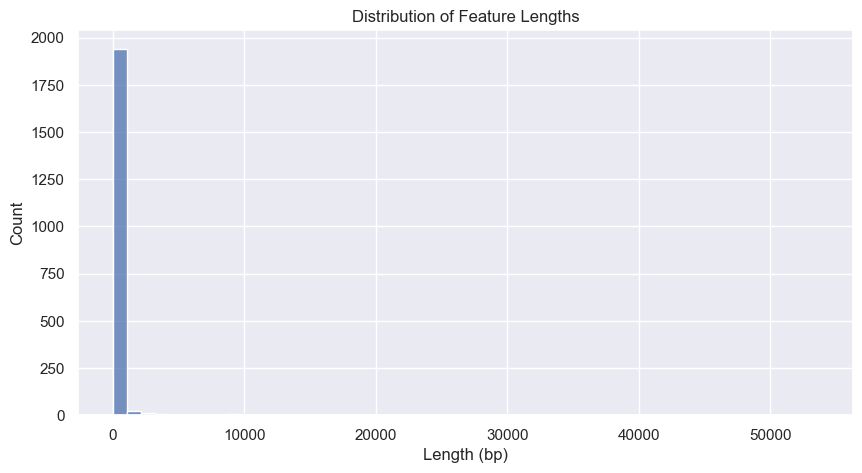


Data loading and preprocessing complete.


In [8]:
# Load feature data using our BED handler
print("Loading feature data...")
feature_df = bed_handler.load_bed12(feature_path)

# Extract transcript IDs from names and add region length
feature_df = feature_df.with_columns([
    # Extract transcript ID from feature name (assumes format: ENST00000123456_...)
    pl.col("name").str.split("_").list.first().alias("transcript_id"),
    
    # Calculate region length
    (pl.col("chromEnd") - pl.col("chromStart")).alias("region_length")
])

# Print basic statistics
print("\nFeature Statistics:")
print(f"Total features loaded: {len(feature_df)}")
print("\nChromosome distribution:")
print(feature_df.group_by("chrom").agg(pl.count()).sort("chrom"))
print("\nStrand distribution:")
print(feature_df.group_by("strand").agg(pl.count()))
print("\nLength statistics:")
print(feature_df.select("region_length").describe())

# Quick length distribution plot
plt.figure(figsize=(10, 5))
sns.histplot(data=feature_df.to_pandas(), x="region_length", bins=50)
plt.title("Distribution of Feature Lengths")
plt.xlabel("Length (bp)")
plt.ylabel("Count")
plt.show()

print("\nData loading and preprocessing complete.")

## Extension Region Identification

Before calculating conservation scores, we need to precisely identify the extension regions by:
1. Loading CDS annotations from GENCODE
2. Identifying the correct CDS start/end positions
3. Determining the extension coordinates based on strand orientation:
   - For + strand: region between chromStart and CDS start
   - For - strand: region between CDS end and chromEnd
4. Validating extension regions

In [9]:
# Load GENCODE annotation
print("Loading GENCODE v47 annotation...")
gr = pr.read_gtf(gencode_path)
cds_annotation = gr[gr.Feature == "CDS"]

print(f"Found {len(cds_annotation)} CDS entries in GENCODE v47")

# Convert pyranges to polars for joining with normalized chromosome names
cds_df = pl.DataFrame({
    "transcript_id": [i.split('.')[0] for i in cds_annotation.transcript_id.to_list()],
    "chrom": [str(x).replace('chr', '') for x in cds_annotation.Chromosome.to_list()],
    "strand": cds_annotation.Strand.to_list(),
    "cds_start": cds_annotation.Start.to_list(),
    "cds_end": cds_annotation.End.to_list(),
    "cds_frame": cds_annotation.Frame.to_list(),
    "gene_name": cds_annotation.gene_name.to_list()
})


Loading GENCODE v47 annotation...
Found 901768 CDS entries in GENCODE v47


In [10]:
# Read leader BED12
trailer_df = bed_handler.load_bed12(trailer_path)
print(f"Loaded {len(trailer_df)} trailer regions")

# Add transcript IDs
trailer_df = trailer_df.with_columns([
   pl.col("name").str.split("_").list.first().alias("transcript_id"),
])


# Join with CDS info
cds_regions = (cds_df
   .group_by("transcript_id")
   .agg([
       pl.col("strand").first().alias("cds_strand"),  # Renamed from strand
       pl.col("gene_name").first().alias("cds_gene_name"),  # Renamed from gene_name
       pl.col("cds_frame").first().alias("cds_frame"),
       pl.when(pl.col("strand").first() == "+")
       .then(pl.min("cds_start"))  
       .otherwise(pl.max("cds_end"))  
       .alias("cds_start_pos")
   ]))

# Now join with feature_df - no column conflicts
feature_df = feature_df.join(
   cds_regions,
   on="transcript_id",
   how="left"
)

# Same for trailer_df
trailer_df = trailer_df.join(
   cds_regions,
   on="transcript_id",
   how="left"
)


def parse_trailer_blocks(transcript_df, feature_df):
   """
   Split transcript blocks into translated/untranslated based on CTE feature matches
   """
   results = []
   
   for transcript_row in transcript_df.iter_rows(named=True):
       transcript_id = transcript_row['transcript_id']
       
       # Get matching feature row
       feature_matches = feature_df.filter(pl.col("transcript_id") == transcript_id)
       if len(feature_matches) == 0:
           continue
           
       feature_row = feature_matches.row(0, named=True)
       
       # Parse blocks
       transcript_starts = [int(x) + transcript_row['chromStart'] for x in transcript_row['blockStarts'].split(',')]
       transcript_sizes = [int(x) for x in transcript_row['blockSizes'].split(',')]
       transcript_ends = [s + sz for s, sz in zip(transcript_starts, transcript_sizes)]
       
       cte_starts = [int(x) + feature_row['chromStart'] for x in feature_row['blockStarts'].split(',')]
       cte_sizes = [int(x) for x in feature_row['blockSizes'].split(',')]
       cte_ends = [s + sz for s, sz in zip(cte_starts, cte_sizes)]
       
       translated_blocks = []
       untranslated_blocks = []

       for t_start, t_end in zip(transcript_starts, transcript_ends):
           translated = False
           
           # Check if transcript block matches/overlaps any CTE block
           for c_start, c_end in zip(cte_starts, cte_ends):
               if t_start == c_start and t_end == c_end:
                   # Exact match
                   translated_blocks.append((t_start, t_end))
                   translated = True
                   break
               elif t_end >= c_start and t_end > c_end:
                   # Split block - transcript block extends beyond CTE
                   translated_blocks.append((c_start, c_end))
                   untranslated_blocks.append((c_end, t_end))
                   translated = True
                   break
                   
           if not translated:
               untranslated_blocks.append((t_start, t_end))
                
       results.append({
            'transcript_id': transcript_id,
            'translated_blocks': translated_blocks,
            'untranslated_blocks': untranslated_blocks,
        })
       
   return pl.DataFrame(results)

split_blocks_df = parse_trailer_blocks(trailer_df, feature_df)

# Join the split blocks with the feature data
# Explicitly select columns from feature_df to avoid duplicates
result_df = (feature_df
    .select([
        "transcript_id",
        "strand",
        "gene_name",
        "chromStart",
        "chromEnd",
        "blockCount",
        "blockSizes",
        "blockStarts"
    ])
    .join(
        split_blocks_df,
        on="transcript_id",
        how="left"
    )
)

# If you need CDS blocks from cds_df, you can process them separately
cds_blocks_df = (cds_df
    .group_by("transcript_id")
    .agg([
        # Combine starts and ends into pairs of [start, end]
        pl.struct([
            pl.col("cds_start"),
            pl.col("cds_end")
        ]).alias("temp_blocks")
    ])
    .with_columns([
        pl.col("temp_blocks").list.eval(
            lambda x: [[s, e] for s, e in zip(x["cds_start"], x["cds_end"])]
        ).alias("cds_blocks")
    ])
    .drop("temp_blocks")
)

# Final join to add CDS information
final_df = result_df.join(
    cds_blocks_df,
    on="transcript_id",
    how="left"
)

# Print validation
print("\nJoined results:")
print(final_df.select([
    "transcript_id",
    "strand",
    "translated_blocks",
    "untranslated_blocks",
    "cds_blocks",
]).head())

Loaded 88838 trailer regions


ColumnNotFoundError: gene_name

Resolved plan until failure:

	---> FAILED HERE RESOLVING 'select' <---
DF ["chrom", "chromStart", "chromEnd", "name"]; PROJECT */18 COLUMNS; SELECTION: None

## Conservation Score Calculation

Calculate both PhyloCSF and PhyloP conservation scores for extension regions using our utility classes. For each region we:
1. Use `ConservationTracker` to access scores
2. Calculate metrics using `ConservationAnalyzer`
3. Store results in a properly structured DataFrame

In [ ]:
# Initialize conservation trackers
conservation_tracker = ConservationTracker(phylocsf_dir, phylop_path)
conservation_analyzer = ConservationAnalyzer(window_size=WINDOW_SIZE)

def calculate_extension_frame(ext_length: int, cds_frame: int, strand: str) -> int:
    """
    Calculate the correct reading frame for CTEs.
    
    Args:
        ext_length: Length of the extension
        cds_frame: Frame of the CDS (0, 1, or 2)
        strand: '+' or '-'
    
    Returns:
        Correct PhyloCSF frame (1, 2, or 3)
    """
    if strand == '+':
        # For + strand CTEs, count forward from CDS end
        offset = (ext_length % 3 + cds_frame) % 3
    else:
        # For - strand CTEs, count backwards from CDS start
        offset = (3 - (ext_length % 3) + cds_frame) % 3
    
    # Convert to PhyloCSF frame numbering (1-based)
    return offset + 1

def calculate_region_scores(df, region_type):
   """Calculate scores for translated or untranslated regions"""
   metrics_lists = {
       f'{region_type}_matched_frame_score': [],
       f'{region_type}_max_frame_score': [],
       f'{region_type}_start_region_score': [],
       f'{region_type}_window_max_score': [],
       f'{region_type}_phylop_mean': [],
       f'{region_type}_frame': [],
       f'{region_type}_length': []
   }
   
   for row in df.iter_rows(named=True):
       current_metrics = {key: None for key in metrics_lists.keys()}
       blocks = row[f'{region_type}_blocks']
       
       if not blocks or row['cds_frame'] is None:
           for key in metrics_lists:
               metrics_lists[key].append(None)
           continue
           
       try:
           # Calculate total length
           total_length = sum(end - start for start, end in blocks)
           current_metrics[f'{region_type}_length'] = total_length
           
           # Calculate frame
           correct_frame = calculate_extension_frame(
               total_length,
               int(row['cds_frame']),
               row['strand']
           )
           current_metrics[f'{region_type}_frame'] = correct_frame
           
           # Get scores for all blocks combined
           all_phylocsf = {1: [], 2: [], 3: []}
           all_phylop = []
           
           for start, end in blocks:
               phylocsf_scores, phylop_scores = conservation_tracker.get_conservation_scores(
                   row['chrom'],
                   start,
                   end,
                   row['strand']
               )
               
               if phylocsf_scores:
                   for frame, scores in phylocsf_scores.items():
                       all_phylocsf[frame].extend(scores)
                       
               if phylop_scores is not None:
                   all_phylop.extend(phylop_scores)
           
           # Calculate metrics
           if any(all_phylocsf.values()):
               frame_means = {
                   frame: np.nanmean(scores) if scores else np.nan
                   for frame, scores in all_phylocsf.items()
               }
               
               current_metrics[f'{region_type}_matched_frame_score'] = frame_means.get(correct_frame)
               current_metrics[f'{region_type}_max_frame_score'] = max(frame_means.values())
               
               scores = all_phylocsf[correct_frame]
               if len(scores) >= 15:
                   current_metrics[f'{region_type}_start_region_score'] = float(np.nanmean(scores[:15]))
               
               if len(scores) >= 30:
                   windows = [np.nanmean(scores[i:i+30]) for i in range(len(scores) - 29)]
                   current_metrics[f'{region_type}_window_max_score'] = float(max(windows))
           
           if all_phylop:
               current_metrics[f'{region_type}_phylop_mean'] = float(np.nanmean(all_phylop))
               
       except Exception as e:
           print(f"Error processing {region_type} region {row['transcript_id']}: {str(e)}")
           
       for key in metrics_lists:
           metrics_lists[key].append(current_metrics[key])
           
   return df.with_columns([
       pl.Series(name, values) for name, values in metrics_lists.items()
   ])




In [8]:
print("Calculating conservation scores...")
# Calculate scores for both regions
translated_scored_df = calculate_region_scores(result_df, 'translated')

Calculating conservation scores...


/tmp/ipykernel_64431/1321223802.py:83: RuntimeWarning: Mean of empty slice
  frame: np.nanmean(scores) if scores else np.nan
/tmp/ipykernel_64431/1321223802.py:92: RuntimeWarning: Mean of empty slice
  current_metrics[f'{region_type}_start_region_score'] = float(np.nanmean(scores[:15]))
/tmp/ipykernel_64431/1321223802.py:95: RuntimeWarning: Mean of empty slice
  windows = [np.nanmean(scores[i:i+30]) for i in range(len(scores) - 29)]


In [9]:
untranslated_translated_scored_df = calculate_region_scores(translated_scored_df, 'untranslated')


/tmp/ipykernel_64431/1321223802.py:95: RuntimeWarning: Mean of empty slice
  windows = [np.nanmean(scores[i:i+30]) for i in range(len(scores) - 29)]
/tmp/ipykernel_64431/1321223802.py:92: RuntimeWarning: Mean of empty slice
  current_metrics[f'{region_type}_start_region_score'] = float(np.nanmean(scores[:15]))
/tmp/ipykernel_64431/1321223802.py:83: RuntimeWarning: Mean of empty slice
  frame: np.nanmean(scores) if scores else np.nan


In [10]:
scored_df = calculate_region_scores(untranslated_translated_scored_df, 'cds')


# Add genome coordinates for reference
scored_df = scored_df.with_columns(
   (pl.col("chrom") + ":" + 
    pl.col("chromStart").cast(pl.Utf8) + "-" +
    pl.col("cds_start_pos").cast(pl.Utf8)
   ).alias("genome_coords")
)


scored_df.head()

chrom,chromStart,chromEnd,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes,blockStarts,transcript_id,region_length,strand_right,gene_name,cds_frame,cds_start_pos,translated_blocks,untranslated_blocks,cds_blocks,translated_matched_frame_score,translated_max_frame_score,translated_start_region_score,translated_window_max_score,translated_phylop_mean,translated_frame,translated_length,untranslated_matched_frame_score,untranslated_max_frame_score,untranslated_start_region_score,untranslated_window_max_score,untranslated_phylop_mean,untranslated_frame,untranslated_length,cds_matched_frame_score,cds_max_frame_score,cds_start_region_score,cds_window_max_score,cds_phylop_mean,cds_length,genome_coords
str,i64,i64,str,i64,str,i64,i64,i64,i64,str,str,str,i64,str,str,null,i64,list[list[i64]],list[list[i64]],list[null],f64,f64,f64,f64,f64,i64,i64,f64,f64,f64,f64,f64,i64,i64,null,null,null,null,null,null,str
"""1""",1233268,1233487,"""ENST00000379198_1""",219,"""+""",1233268,1233487,0,1,"""219""","""0""","""ENST00000379198""",219,"""+""","""B3GALT6""",null,1232278,"[[1233268, 1233487]]","[[1233487, 1235041]]",[],-25.396804,-21.587219,-10.111867,-8.0797,-1.742338,1,219,-17.011003,-16.925286,-36.821266,-1.4171,-0.619773,1,1554,null,null,null,null,null,null,"""1:1233268-1232278"""
"""1""",1534072,1534258,"""ENST00000378756_1""",186,"""+""",1534072,1534258,0,1,"""186""","""0""","""ENST00000378756""",186,"""+""","""ATAD3A""",null,1512268,"[[1534072, 1534258]]","[[1534258, 1534685]]",[],-22.405565,-19.107575,-35.204932,-12.4265,-1.340183,1,186,-25.672098,-21.09366,-29.9162,-9.6347,-0.991473,2,427,null,null,null,null,null,null,"""1:1534072-1512268"""
"""1""",6621637,6621790,"""ENST00000377648_1""",153,"""+""",6621637,6621790,0,1,"""153""","""0""","""ENST00000377648""",153,"""+""","""PHF13""",null,6614066,"[[6621637, 6621790]]","[[6621790, 6624030]]",[],-20.253392,-14.597824,-36.789733,-9.9985,2.662556,1,153,-21.55481,-21.026102,-11.945933,-0.4692,0.986934,3,2240,null,null,null,null,null,null,"""1:6621637-6614066"""
"""1""",7779645,7779765,"""ENST00000054666_1""",120,"""+""",7779645,7779765,0,1,"""120""","""0""","""ENST00000054666""",120,"""+""","""VAMP3""",null,7771383,"[[7779645, 7779765]]","[[7779765, 7781432]]",[],-18.328,-16.893492,-19.9578,-7.2825,1.772508,1,120,-24.038323,-22.180411,-25.496867,-3.6536,0.611187,3,1667,null,null,null,null,null,null,"""1:7779645-7771383"""
"""1""",7985054,7985096,"""ENST00000338639_1""",42,"""+""",7985054,7985096,0,1,"""42""","""0""","""ENST00000338639""",42,"""+""","""PARK7""",null,7962785,"[[7985054, 7985096]]","[[7985096, 7985505]]",[],-22.660547,-17.64781,-9.4006,-23.781166,-0.730548,1,42,-26.75011,-18.576265,-21.4066,-10.0117,-0.748985,2,409,null,null,null,null,null,null,"""1:7985054-7962785"""


## High-Confidence Extension Analysis

Filter and categorize the extensions based on conservation scores:
1. Filter for positive PhyloCSF scores (indicating coding potential)
2. Sort by conservation strength
3. Separate novel vs. overlapping extensions
4. Generate visualizations and summary statistics

In [11]:
def write_scored_bed(df, score_col, output_path, normalize=False, scale_factor=1000):
    """
    Write BED file with specified score column in proper BED format.
    
    Args:
        df: polars DataFrame with genomic data
        score_col: name of column containing scores
        output_path: path to write BED file
        normalize: if True, normalize scores to 0-1000 range for genome browser (default: False)
        scale_factor: scaling factor for normalization (default: 1000)
    """
    
    # Start with score handling
    score_expr = (
        pl.when(pl.col(score_col).is_null() | pl.col(score_col).is_nan())
        .then(0)
        .otherwise(
            pl.when(normalize)
            .then(
                # Normalize to 0-1000 for genome browser
                ((pl.col(score_col) - pl.col(score_col).filter(~pl.col(score_col).is_nan()).min()) / 
                 (pl.col(score_col).filter(~pl.col(score_col).is_nan()).max() - 
                  pl.col(score_col).filter(~pl.col(score_col).is_nan()).min()) * scale_factor)
                .floor()
                .cast(pl.Int64)
                .clip(0, 1000)
            )
            .otherwise(
                # Keep original scores, just handle null/nan
                pl.col(score_col)
            )
        )
    )
    
    # Create BED format DataFrame
    bed_df = (df
        .filter(~pl.col(score_col).is_null() & ~pl.col(score_col).is_nan())
        .with_columns([
            # Add 'chr' prefix to chrom
            pl.format("chr{}", pl.col("chrom")).alias("chr_name"),
            
            # Handle start/end coordinates ensuring start <= end
            pl.when(pl.col("chromStart") > pl.col("chromEnd"))
            .then(pl.col("chromEnd"))
            .otherwise(pl.col("chromStart"))
            .alias("start"),
            
            pl.when(pl.col("chromStart") > pl.col("chromEnd"))
            .then(pl.col("chromStart"))
            .otherwise(pl.col("chromEnd"))
            .alias("end"),
            
            # Add processed scores
            score_expr.alias("bed_score")
        ])
        # Select and reorder columns for BED format
        .select([
            "chr_name",
            "start",
            "end",
            "transcript_id",
            "bed_score",
            "strand"
        ])
        # Filter out invalid entries
        .filter(
            (pl.col("start").is_not_null()) &
            (pl.col("end").is_not_null())
        ))
    
    # Write the BED file
    bed_df.write_csv(
        output_path, 
        separator="\t", 
        include_header=False
    )
    
    # Print summary statistics
    print(f"Wrote {len(bed_df)} entries to {output_path}")
    print("\nScore statistics:")
    print(bed_df.select("bed_score").describe())
    print("\nFirst few lines of BED file:")
    print(bed_df.head())
    
    return bed_df


Score statistics:
shape: (10, 6)
┌─────────────────┬───────────┬─────────────────┬────────────────┬────────────────┬────────────────┐
│ transcript_id   ┆ gene_name ┆ translated_matc ┆ translated_phy ┆ untranslated_m ┆ untranslated_p │
│ ---             ┆ ---       ┆ hed_frame_score ┆ lop_mean       ┆ atched_frame_s ┆ hylop_mean     │
│ str             ┆ str       ┆ ---             ┆ ---            ┆ co…            ┆ ---            │
│                 ┆           ┆ f64             ┆ f64            ┆ ---            ┆ f64            │
│                 ┆           ┆                 ┆                ┆ f64            ┆                │
╞═════════════════╪═══════════╪═════════════════╪════════════════╪════════════════╪════════════════╡
│ ENST00000379198 ┆ B3GALT6   ┆ -25.396804      ┆ -1.742338      ┆ -17.011003     ┆ -0.619773      │
│ ENST00000378756 ┆ ATAD3A    ┆ -22.405565      ┆ -1.340183      ┆ -25.672098     ┆ -0.991473      │
│ ENST00000377648 ┆ PHF13     ┆ -20.253392      ┆ 2.66255

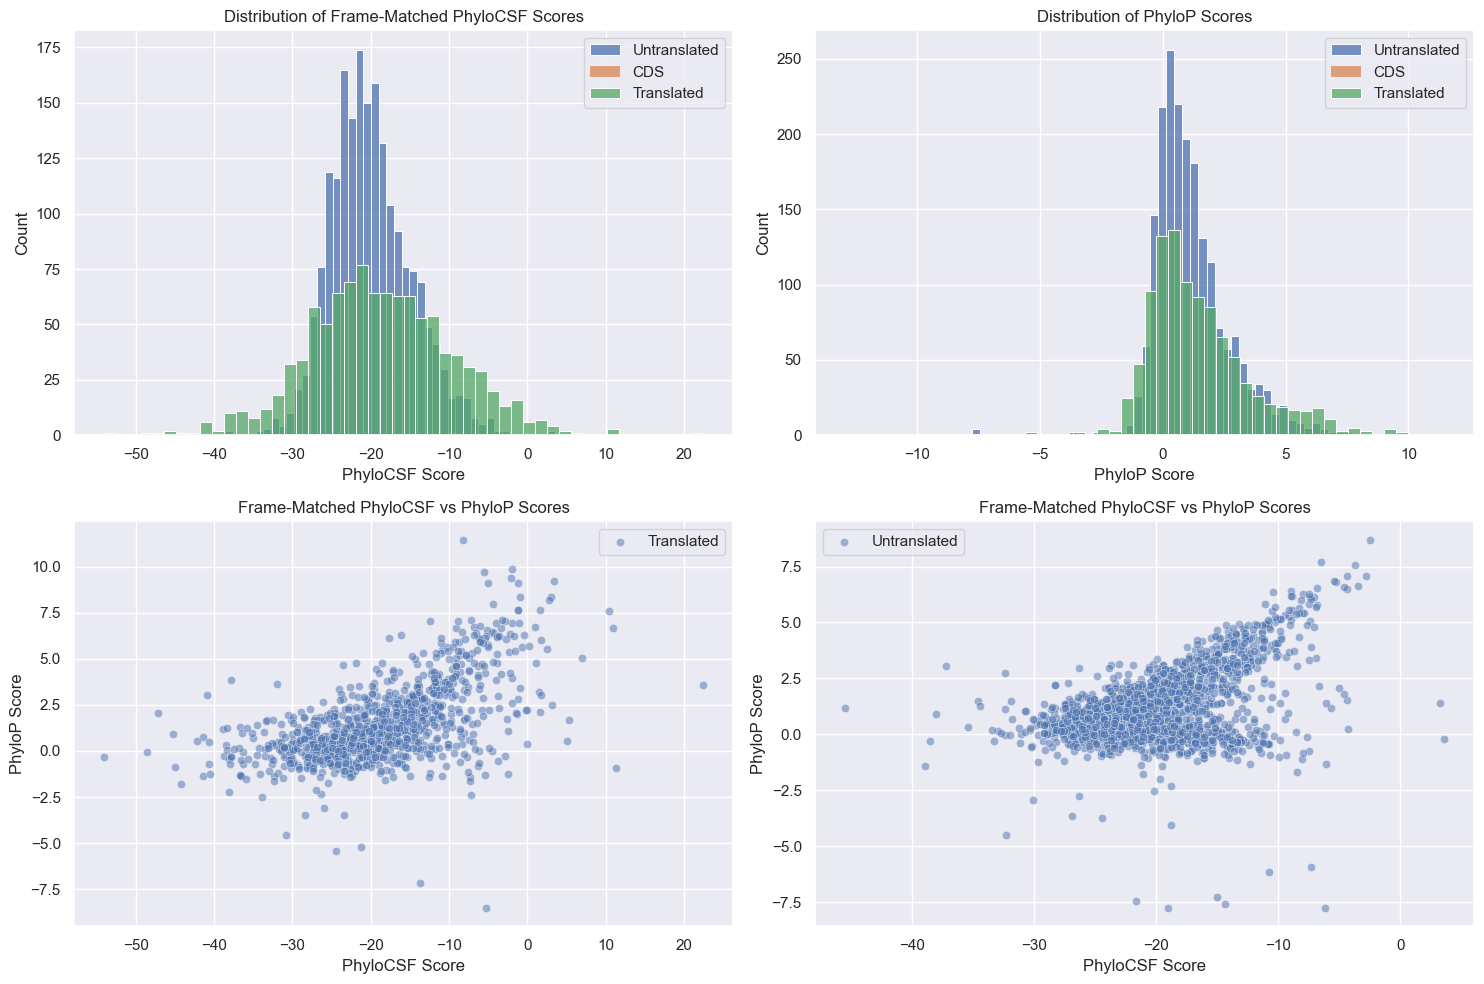


Writing translated matched_frame BED file...
Wrote 1025 entries to ../results/cte_trailer/bed/trailer_translated_matched_frame.bed

Score statistics:
shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ bed_score  │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 1025.0     │
│ null_count ┆ 0.0        │
│ mean       ┆ -18.70346  │
│ std        ┆ 9.245763   │
│ min        ┆ -54.061    │
│ 25%        ┆ -24.704834 │
│ 50%        ┆ -19.026959 │
│ 75%        ┆ -12.551402 │
│ max        ┆ 22.446939  │
└────────────┴────────────┘

First few lines of BED file:
shape: (5, 6)
┌──────────┬─────────┬─────────┬─────────────────┬────────────┬────────┐
│ chr_name ┆ start   ┆ end     ┆ transcript_id   ┆ bed_score  ┆ strand │
│ ---      ┆ ---     ┆ ---     ┆ ---             ┆ ---        ┆ ---    │
│ str      ┆ i64     ┆ i64     ┆ str             ┆ f64        ┆ str    │
╞══════════╪═════════╪═════════╪═════════════════╪════════════╪════════╡
│ chr1

In [23]:
# Show distribution of scores for both regions
print("\nScore statistics:")
print(scored_df.select([
  "transcript_id",
  "gene_name",
  "translated_matched_frame_score",
  "translated_phylop_mean",
  "untranslated_matched_frame_score", 
  "untranslated_phylop_mean"
]).head(10))

# Create visualization comparing translated vs untranslated regions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

# Matched frame scores distribution

sns.histplot(
   data=scored_df.to_pandas(),
   x="untranslated_matched_frame_score", 
   label="Untranslated",
   bins=50,
   ax=axes[0]
)
sns.histplot(
   data=scored_df.to_pandas(),
   x="cds_matched_frame_score",
   label="CDS",
   bins=50,
   ax=axes[0]
)
sns.histplot(
   data=scored_df.to_pandas(),
   x="translated_matched_frame_score",
   label="Translated",
   bins=50,
   ax=axes[0]
)
axes[0].set_title("Distribution of Frame-Matched PhyloCSF Scores")
axes[0].set_xlabel("PhyloCSF Score")
axes[0].legend()

# PhyloP distributions

sns.histplot(
   data=scored_df.to_pandas(),
   x="untranslated_phylop_mean",
   label="Untranslated",
   bins=50,
   ax=axes[1]
)
sns.histplot(
   data=scored_df.to_pandas(),
   x="cds_phylop_mean",
   label="CDS",
   bins=50,
   ax=axes[1]
)
sns.histplot(
   data=scored_df.to_pandas(),
   x="translated_phylop_mean",
   label="Translated",
   bins=50,
   ax=axes[1]
)
axes[1].set_title("Distribution of PhyloP Scores")
axes[1].set_xlabel("PhyloP Score")
axes[1].legend()

# PhyloCSF vs PhyloP - Translated
sns.scatterplot(
   data=scored_df.to_pandas(),
   x="translated_matched_frame_score",
   y="translated_phylop_mean",
   alpha=0.5,
   ax=axes[2],
   label="Translated"
)
axes[2].set_title("Frame-Matched PhyloCSF vs PhyloP Scores")
axes[2].set_xlabel("PhyloCSF Score")
axes[2].set_ylabel("PhyloP Score")
axes[2].legend()

# PhyloCSF vs PhyloP - Untranslated
sns.scatterplot(
   data=scored_df.to_pandas(),
   x="untranslated_matched_frame_score",
   y="untranslated_phylop_mean",
   alpha=0.5,
   ax=axes[3],
   label="Untranslated"
)
axes[3].set_title("Frame-Matched PhyloCSF vs PhyloP Scores")
axes[3].set_xlabel("PhyloCSF Score")
axes[3].set_ylabel("PhyloP Score")
axes[3].legend()

plt.tight_layout()
plt.show()

# Write BED files for both regions
for region in ['translated', 'untranslated']:
   for score_type, column in {
       "matched_frame": f"{region}_matched_frame_score",
       "phylop": f"{region}_phylop_mean",
       "window_max": f"{region}_window_max_score"
   }.items():
       output_path = RESULTS_DIR / "bed" / f"trailer_{region}_{score_type}.bed"
       print(f"\nWriting {region} {score_type} BED file...")
       write_scored_bed(scored_df, column, output_path)

# Print diagnostics
print("\nScore column statistics:")
for region in ['translated', 'untranslated']:
   for metric in ["matched_frame_score", "phylop_mean", "window_max_score"]:
       col = f"{region}_{metric}"
       print(f"\n{col}:")
       print(f"Total values: {len(scored_df)}")
       print(f"Null values: {scored_df.filter(pl.col(col).is_null()).height}")
       print(f"NaN values: {scored_df.filter(pl.col(col).is_nan()).height}")
       print(f"Negative values: {scored_df.filter(pl.col(col) < 0).height}")
       print("Overall statistics:")
       print(scored_df.select(pl.col(col)).describe())

## Finding Novel Extension Regions

After calculating conservation scores for all potential N-terminal extensions, we need to identify which ones are truly novel (i.e., don't overlap with known coding sequences in other transcripts). This requires:

1. Prerequisites:
  - Bedtools installed (`conda install -c bioconda bedtools`)
  - Our scored BED files from the conservation analysis
  - GENCODE v47 CDS annotations in BED format

2. Steps to identify novel extensions:

```bash
# First convert GENCODE GTF CDS regions to BED
# If using UCSC genome browser coordinates (our case):
awk '$3=="CDS" {print $1"\t"$4-1"\t"$5}' data/raw/gencode.v47.annotation.gtf > gencode.v47.cds.bed


# Use bedtools ictersect to find non-overlapping regions - Examples
# For matched frame scores:
bedtools intersect -v -a cte_matched_frame_20241031.bed -b gencode.v47.cds.bed > novel_cte_matched_frame_20241031.bed

# For PhyloP scores:
bedtools intersect -v -a cte_phylop_20241031.bed -b gencode.v47.cds.bed > novel_cte_phylop_20241031.bed

# For window max scores:
bedtools intersect -v -a cte_window_max_20241031.bed -b gencode.v47.cds.bed > novel_cte_window_max_20241031.bed

In [ ]:
import pandas as pd

In [24]:
def generate_novel_beds(scored_df, gencode_pyranges, output_dir, date_str):
    """
    Generate both full and novel (non-CDS-overlapping) BED files
    """
    # First get CDS regions from GENCODE
    print("Loading GENCODE CDS regions...")
    cds_gr = gencode_pyranges[gencode_pyranges.Feature == "CDS"]
    
    # Convert CDS to BED format (chr, start, end)
    cds_bed = pd.DataFrame({
        'Chromosome': cds_gr.Chromosome,
        'Start': cds_gr.Start,
        'End': cds_gr.End
    })
    cds_gr = pr.PyRanges(cds_bed)
    
    # Generate BED files for different score types
    score_pairs = {
        "phylocsf": ("translated_frame_score", "untranslated_frame_score"),
        "phylop": ("translated_phylop", "untranslated_phylop")
    }
    
    results = {}
    for score_type, (translated_col, untranslated_col) in score_pairs.items():
        # Generate full BED file
        full_path = output_dir / f"intron_{score_type}_{date_str}.bed"
        print(f"\nGenerating {score_type} BED files...")
        full_bed_df = write_scored_bed(scored_df, translated_col, untranslated_col, full_path)
        
        # Convert to PyRanges
        full_gr = pr.PyRanges(
            pd.DataFrame({
                'Chromosome': full_bed_df['chr_name'],
                'Start': full_bed_df['start'],
                'End': full_bed_df['end'],
                'Name': full_bed_df['feature_name'],
                'Score': full_bed_df['bed_score'],
                'Strand': full_bed_df['strand']
            })
        )
        
        # Find non-overlapping regions
        novel_gr = full_gr.subtract(cds_gr)
        
        # Save novel regions
        novel_path = output_dir / f"novel_intron_{score_type}_{date_str}.bed"
        novel_gr.to_bed(novel_path)
        
        print(f"Wrote {len(full_gr)} regions to {full_path}")
        print(f"Wrote {len(novel_gr)} novel regions to {novel_path}")
        
        results[score_type] = {
            'full': full_gr,
            'novel': novel_gr
        }
    
    return results

date_str = datetime.now().strftime("%Y%m%d")


# Use in your notebook after scoring:
novel_results = generate_novel_beds(
    scored_df=scored_df,
    gencode_path=gr,
    output_dir=RESULTS_DIR / "novel_bed",
    date_str=date_str
)

# Print summary statistics
for score_type in novel_results:
    full_count = len(novel_results[score_type]['full'])
    novel_count = len(novel_results[score_type]['novel'])
    print(f"\n{score_type} results:")
    print(f"Total regions: {full_count}")
    print(f"Novel regions: {novel_count}")
    print(f"Percentage novel: {(novel_count/full_count)*100:.1f}%")

Loading GENCODE CDS regions...


NameError: name 'pd' is not defined

## Results Output Organization

We should save both figures and data files for reproducibility and future reference. Here's what we should output:

### Figures
1. **Distribution Plots** (`results/cte/figures/`)
  - Score distributions:
    ```python
    # Distribution plots (4-panel)
    fig.savefig(RESULTS_DIR / "figures" / f"cte_score_distributions_{date_str}.pdf")
    fig.savefig(RESULTS_DIR / "figures" / f"cte_score_distributions_{date_str}.png", dpi=300)
    ```

2. **Correlation Plots**
  - PhyloCSF vs PhyloP
  - Score vs length relationships
  - Separate plots for clarity

### Tables/Data Files 
1. **Summary Statistics** (`results/cte/tables/`)


ComputeError: CSV format does not support nested data

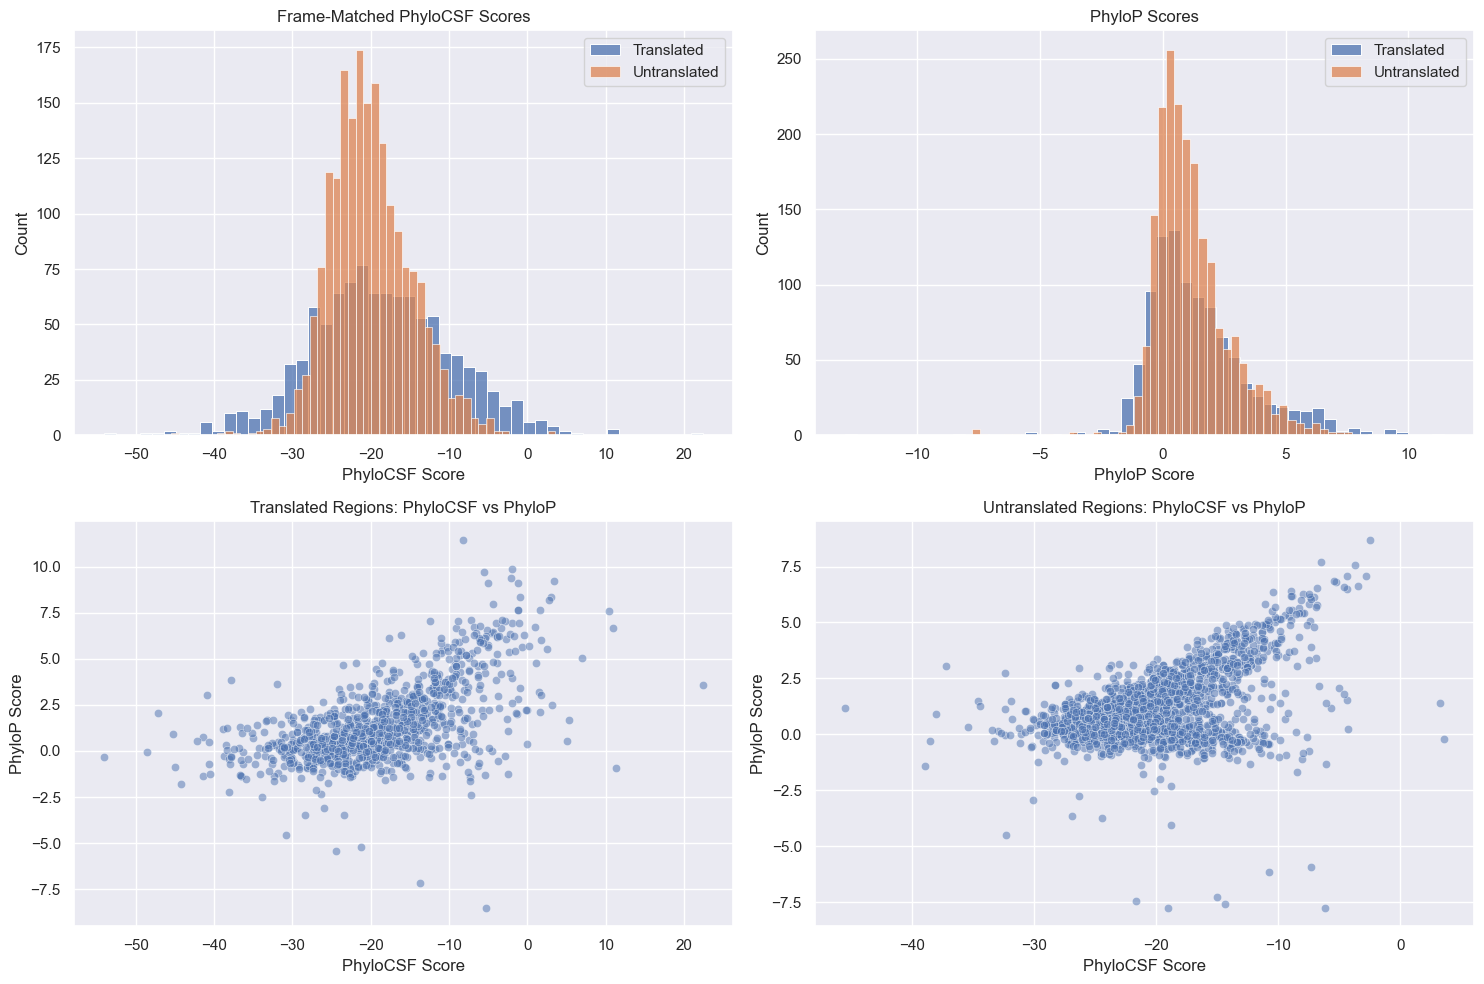

In [ ]:
# Create directory structure
RESULTS_DIR = Path("../results/cte_trailer")  # Changed directory name
for subdir in ["figures", "tables", "bed"]:
   (RESULTS_DIR / subdir).mkdir(parents=True, exist_ok=True)

date_str = datetime.now().strftime("%Y%m%d")

# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

# Frame scores comparison
for region in ['translated', 'untranslated']:
   sns.histplot(
       data=scored_df.to_pandas(),
       x=f"{region}_matched_frame_score",
       bins=50,
       ax=axes[0],
       label=region.capitalize()
   )
axes[0].set_title("Frame-Matched PhyloCSF Scores")
axes[0].set_xlabel("PhyloCSF Score")
axes[0].legend()

# PhyloP comparison
for region in ['translated', 'untranslated']:
   sns.histplot(
       data=scored_df.to_pandas(),
       x=f"{region}_phylop_mean",
       bins=50,
       ax=axes[1],
       label=region.capitalize()
   )
axes[1].set_title("PhyloP Scores")
axes[1].set_xlabel("PhyloP Score")
axes[1].legend()

# PhyloCSF vs PhyloP for translated
sns.scatterplot(
   data=scored_df.to_pandas(),
   x="translated_matched_frame_score",
   y="translated_phylop_mean",
   alpha=0.5,
   ax=axes[2]
)
axes[2].set_title("Translated Regions: PhyloCSF vs PhyloP")
axes[2].set_xlabel("PhyloCSF Score")
axes[2].set_ylabel("PhyloP Score")

# PhyloCSF vs PhyloP for untranslated
sns.scatterplot(
   data=scored_df.to_pandas(),
   x="untranslated_matched_frame_score",
   y="untranslated_phylop_mean",
   alpha=0.5,
   ax=axes[3]
)
axes[3].set_title("Untranslated Regions: PhyloCSF vs PhyloP")
axes[3].set_xlabel("PhyloCSF Score")
axes[3].set_ylabel("PhyloP Score")

plt.tight_layout()

# Save figures
fig.savefig(RESULTS_DIR / "figures" / f"leader_score_distributions_{date_str}.pdf")
fig.savefig(RESULTS_DIR / "figures" / f"leader_score_distributions_{date_str}.png", dpi=300)

# Save summary statistics for both regions
for region in ['translated', 'untranslated']:
   metrics = [
       f"{region}_matched_frame_score",
       f"{region}_max_frame_score",
       f"{region}_start_region_score",
       f"{region}_window_max_score",
       f"{region}_phylop_mean",
       f"{region}_length"
   ]
   summary_stats = scored_df.select(metrics).describe()
   summary_stats.write_csv(RESULTS_DIR / "tables" / f"leader_{region}_summary_{date_str}.tsv", separator="\t")

# Save BED files for both regions
# Function to unpack blocks into separate rows
def unpack_blocks(df: pl.DataFrame, block_col: str) -> pl.DataFrame:
    unpacked_rows = []
    for row in df.iter_rows(named=True):
        blocks = row[block_col]
        if not blocks:
            continue
        for start, end in blocks:
            row_dict = {k: v for k, v in row.items() if k != block_col}
            row_dict['block_start'] = start
            row_dict['block_end'] = end
            unpacked_rows.append(row_dict)
    return pl.DataFrame(unpacked_rows)

def unpack_blocks_to_strings(df: pl.DataFrame) -> pl.DataFrame:
   unpacked = []
   for row in df.iter_rows(named=True):
       new_row = {k:v for k,v in row.items() if k not in ['translated_blocks', 'untranslated_blocks']}
       
       translated = row['translated_blocks'] or []
       untranslated = row['untranslated_blocks'] or []
       
       new_row['translated_block_starts'] = str([start for start, _ in translated])
       new_row['translated_block_ends'] = str([end for _, end in translated])
       new_row['untranslated_block_starts'] = str([start for start, _ in untranslated])
       new_row['untranslated_block_ends'] = str([end for _, end in untranslated])
       
       unpacked.append(new_row)
   
   return pl.DataFrame(unpacked)

scored_df = unpack_blocks_to_strings(scored_df)

scored_df.write_csv(RESULTS_DIR / "tables" / f"leader_full_results_{date_str}.tsv", separator="\t")

# Save high-confidence results for both regions
high_conf = scored_df.filter(
   (pl.col("translated_matched_frame_score") > 10) &
   (pl.col("translated_phylop_mean") > 2)
)
high_conf.write_csv(RESULTS_DIR / "tables" / f"leader_high_confidence_{date_str}.tsv", separator="\t")


# For BED files, use the unpacked dataframes
for region in ['translated', 'untranslated']:
   for score_type, column in {
       "matched_frame": f"{region}_matched_frame_score",
       "phylop": f"{region}_phylop_mean",
       "window_max": f"{region}_window_max_score"
   }.items():
       output_path = RESULTS_DIR / "bed" / f"leader_{region}_{score_type}_{date_str}.bed"
       write_scored_bed(scored_df, column, output_path)

print(f"Results saved in {RESULTS_DIR}")